In [17]:
# =============================================================================
# PRODUCT RECOMMENDATION SYSTEM (with Polars - 10x faster!)
# =============================================================================
# This notebook builds a recommendation system using:
# 1. Collaborative Filtering (Item-based using KNN)
# 2. Content-Based Filtering (Product similarity using TF-IDF)
#
# Using Polars for fast data loading and processing
# =============================================================================

# Install requirements (uncomment and run if needed):
# !pip install polars pyarrow numpy scipy scikit-learn matplotlib joblib

# Required packages:
# - polars >= 0.20.0      (fast DataFrame library)
# - pyarrow >= 14.0.0     (required by Polars for file I/O)
# - numpy >= 1.26.0       (numerical computing)
# - scipy >= 1.12.0       (sparse matrices)
# - scikit-learn >= 1.4.0 (ML algorithms: KNN, TF-IDF)
# - matplotlib >= 3.8.0   (plotting)
# - joblib >= 1.3.0       (model saving)

import polars as pl
import numpy as np
import json
from scipy.sparse import csr_matrix, save_npz
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

# Set Polars to show more rows
pl.Config.set_tbl_rows(10)

print("✅ Libraries loaded successfully!")
print(f"   Polars version: {pl.__version__}")
print(f"   NumPy version: {np.__version__}")


✅ Libraries loaded successfully!
   Polars version: 1.36.1
   NumPy version: 2.4.0


In [18]:
# =============================================================================
# 1. LOAD DATA (with Polars - super fast!)
# =============================================================================

SAMPLE_SIZE = 100000  # Reviews to load

# Load reviews (user-product interactions)
reviews_path = "../dataset/Home_and_Kitchen.json"
reviews_raw = pl.read_ndjson(reviews_path, n_rows=SAMPLE_SIZE)
print(f"✅ Reviews loaded: {reviews_raw.shape}")
print(f"   Columns: {reviews_raw.columns}")

# Rename columns to match expected names
# The dataset uses: reviewerID, overall, asin
# We need: user_id, rating, parent_asin (and keep asin)
reviews = reviews_raw.rename({
    'reviewerID': 'user_id',
    'overall': 'rating',
}).with_columns([
    pl.col('asin').alias('parent_asin')  # Add parent_asin as copy of asin
])
# Now reviews has: user_id, rating, asin, parent_asin (and other columns)

# Load ALL product metadata (no limit - we need complete catalog!)
meta_path = "../dataset/meta_Home_and_Kitchen.json"
meta_raw = pl.read_ndjson(meta_path, n_rows=SAMPLE_SIZE)  # Load ALL metadata
print(f"✅ Products loaded: {meta_raw.shape}")
print(f"   Columns: {meta_raw.columns}")

# Rename metadata columns if needed
if 'parent_asin' not in meta_raw.columns and 'asin' in meta_raw.columns:
    meta = meta_raw.rename({'asin': 'parent_asin'})
else:
    meta = meta_raw

# Preview
print("\n📊 Sample Reviews:")
print(reviews.select(['user_id', 'asin', 'parent_asin', 'rating']).head())
print("\n📦 Sample Products:")
if 'title' in meta.columns:
    print(meta.select(['parent_asin', 'title']).head())
else:
    print(meta.head())

# Check overlap between reviews and metadata
review_products = set(reviews['parent_asin'].unique().to_list())
meta_products = set(meta['parent_asin'].unique().to_list())
overlap = review_products.intersection(meta_products)
print(f"\n📊 Product Overlap:")
print(f"   Products in reviews: {len(review_products):,}")
print(f"   Products in metadata: {len(meta_products):,}")
print(f"   Matching products: {len(overlap):,} ({100*len(overlap)/len(review_products):.1f}%)")


✅ Reviews loaded: (100000, 12)
   Columns: ['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'image']
✅ Products loaded: (100000, 18)
   Columns: ['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2', 'brand', 'feature', 'rank', 'also_view', 'main_cat', 'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes']

📊 Sample Reviews:
shape: (5, 4)
┌────────────────┬────────────┬─────────────┬────────┐
│ user_id        ┆ asin       ┆ parent_asin ┆ rating │
│ ---            ┆ ---        ┆ ---         ┆ ---    │
│ str            ┆ str        ┆ str         ┆ f64    │
╞════════════════╪════════════╪═════════════╪════════╡
│ A3NSN9WOX8470M ┆ 0006564224 ┆ 0006564224  ┆ 5.0    │
│ A2AMX0AJ2BUDNV ┆ 0006564224 ┆ 0006564224  ┆ 5.0    │
│ A8LUWTIPU9CZB  ┆ 0560467893 ┆ 0560467893  ┆ 5.0    │
│ AABKIIHAL0L66  ┆ 0560467893 ┆ 0560467893  ┆ 4.0    │
│ A3DA0KIQ5OBK5C ┆ 0560467893 ┆ 056046789

📈 RECOMMENDATION SYSTEM STATISTICS
Total Users:        94,150
Total Products:     579
Total Interactions: 100,000
Matrix Sparsity:    99.82%


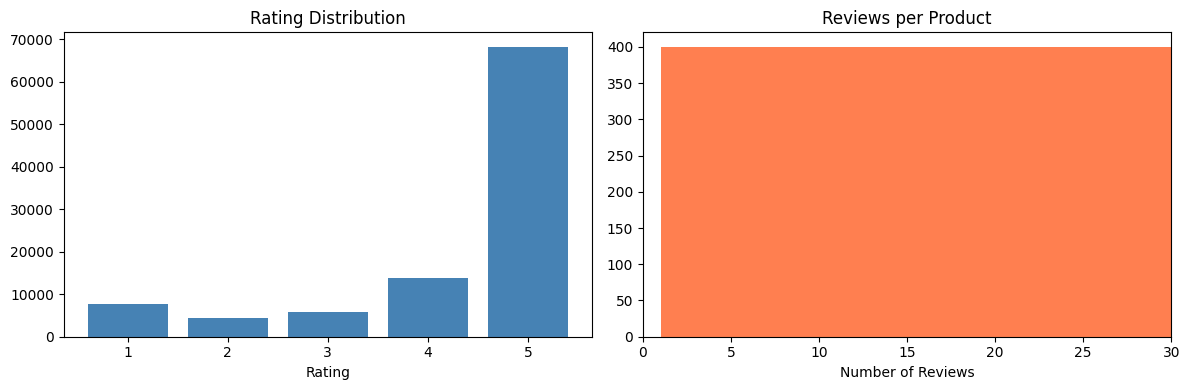

In [19]:
# =============================================================================
# 2. EXPLORATORY DATA ANALYSIS
# =============================================================================

n_users = reviews['user_id'].n_unique()
n_products = reviews['parent_asin'].n_unique()
n_interactions = len(reviews)
sparsity = 1 - (n_interactions / (n_users * n_products))

print("=" * 50)
print("📈 RECOMMENDATION SYSTEM STATISTICS")
print("=" * 50)
print(f"Total Users:        {n_users:,}")
print(f"Total Products:     {n_products:,}")
print(f"Total Interactions: {n_interactions:,}")
print(f"Matrix Sparsity:    {sparsity:.2%}")
print("=" * 50)

# Rating distribution (using native Python lists - no pandas needed!)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Get rating counts as lists
rating_data = reviews.group_by('rating').len().sort('rating')
ratings = rating_data['rating'].to_list()
counts = rating_data['len'].to_list()
axes[0].bar(ratings, counts, color='steelblue')
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')

# Reviews per product histogram
product_counts = reviews.group_by('parent_asin').len()['len'].to_list()
axes[1].hist(product_counts, bins=50, color='coral')
axes[1].set_title('Reviews per Product')
axes[1].set_xlabel('Number of Reviews')
axes[1].set_xlim(0, 30)

plt.tight_layout()
plt.show()


In [20]:
# =============================================================================
# 3. DATA PREPROCESSING
# =============================================================================

# Filter for products with enough reviews (cold start problem)
MIN_REVIEWS = 3

# Count reviews per product
product_counts = reviews.group_by('parent_asin').len().rename({'len': 'count'})
popular_products = product_counts.filter(pl.col('count') >= MIN_REVIEWS)['parent_asin']

# Filter reviews to only include popular products
df = reviews.filter(pl.col('parent_asin').is_in(popular_products))

print(f"Filtered to products with >= {MIN_REVIEWS} reviews")
print(f"Interactions: {len(df):,}")
print(f"Products: {df['parent_asin'].n_unique():,}")
print(f"Users: {df['user_id'].n_unique():,}")

Filtered to products with >= 3 reviews
Interactions: 99,931
Products: 531
Users: 94,093


## 📐 MATH: User-Item Matrix (Binary for Behavioral CF)

### What is a User-Item Matrix?

A **User-Item Matrix** is a 2D matrix where:
- **Rows** = Users
- **Columns** = Products
- **Values** = **BINARY (0 or 1)** for behavioral collaborative filtering

### ⚠️ Why Binary (0/1) and NOT Ratings?

For **"Customers who bought this also bought..."** we care about:
- ✅ **Did the user interact with the product?** (behavioral pattern)
- ❌ NOT "What rating did they give?" (that's a rating prediction problem)

Using ratings would find products with **similar rating distributions**, not products **bought by the same users**.

### Binary User-Item Matrix:
```
                Product_1  Product_2  Product_3  Product_4
    User_A         1          0          1          0      ← Bought products 1 & 3
    User_B         0          1          0          1      ← Bought products 2 & 4
    User_C         1          0          1          0      ← Bought products 1 & 3 (like User_A!)
    User_D         0          1          0          1      ← Bought products 2 & 4 (like User_B!)
```

**Result:** Products 1 & 3 are similar (same users bought both), Products 2 & 4 are similar.

### Sparsity Problem

**Sparsity** = (Number of zeros) / (Total cells)

If we have:
- 1,000 users
- 10,000 products
- 50,000 interactions (reviews)

```
Total cells = 1,000 × 10,000 = 10,000,000
Sparsity = (10,000,000 - 50,000) / 10,000,000 = 99.5%
```

**99.5% of the matrix is empty!** This is why we use **sparse matrices** (only store non-zero values).


In [21]:
# =============================================================================
# 4. BUILD USER-ITEM MATRIX (for Collaborative Filtering)
# =============================================================================
# IMPORTANT: We use BINARY values (0/1) NOT ratings!
# This captures BEHAVIORAL patterns: "did user interact with product?"
# NOT "what rating did user give?" which would be a different problem.

# Get unique user-product pairs (binary: interacted or not)
df_grouped = df.group_by(['user_id', 'parent_asin']).agg(pl.lit(1).alias('interaction'))

# Get unique users and products
user_ids = df_grouped['user_id'].unique().to_list()
product_ids = df_grouped['parent_asin'].unique().to_list()

# Create mappings
user_to_idx = {user: idx for idx, user in enumerate(user_ids)}
idx_to_user = {idx: user for user, idx in user_to_idx.items()}

product_to_idx = {product: idx for idx, product in enumerate(product_ids)}
idx_to_product = {idx: product for product, idx in product_to_idx.items()}

# Convert to numpy for sparse matrix creation
user_indices = np.array([user_to_idx[u] for u in df_grouped['user_id'].to_list()])
product_indices = np.array([product_to_idx[p] for p in df_grouped['parent_asin'].to_list()])

# BINARY values: 1 = user interacted with product, 0 = no interaction
interactions = np.ones(len(user_indices))  # All 1s for interactions

# Sparse matrix (users x products) with BINARY values
user_item_matrix = csr_matrix(
    (interactions, (user_indices, product_indices)),
    shape=(len(user_ids), len(product_ids))
)

# Item-user matrix (transposed for item-based CF)
item_user_matrix = user_item_matrix.T

print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"Item-User Matrix Shape: {item_user_matrix.shape}")
print(f"Non-zero entries (interactions): {user_item_matrix.nnz:,}")
print(f"Unique products: {len(product_ids):,}")
print(f"\n✅ Using BINARY (0/1) values for behavioral patterns!")


User-Item Matrix Shape: (94093, 531)
Item-User Matrix Shape: (531, 94093)
Non-zero entries (interactions): 99,339
Unique products: 531

✅ Using BINARY (0/1) values for behavioral patterns!


In [22]:
# =============================================================================
# 5. COLLABORATIVE FILTERING (Item-Based KNN)
# =============================================================================
# "Users who bought this also bought..."

# Train KNN model on item-user matrix
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn_model.fit(item_user_matrix)

print("✅ Collaborative Filtering model trained!")

def get_similar_products_cf(product_asin, n_recommendations=5):
    """
    Get similar products using Collaborative Filtering.
    Based on users who interacted with similar products.
    """
    if product_asin not in product_to_idx:
        return f"Product {product_asin} not found in training data"
    
    # Get product index
    product_idx = product_to_idx[product_asin]
    
    # Find similar products
    distances, indices = knn_model.kneighbors(
        item_user_matrix[product_idx].reshape(1, -1),
        n_neighbors=n_recommendations + 1
    )
    
    # Convert to product ASINs (skip first as it's the query product)
    similar_products = []
    for i, idx in enumerate(indices[0][1:]):
        similar_products.append({
            'asin': idx_to_product[idx],
            'similarity': round(1 - distances[0][i+1], 3)  # Convert distance to similarity
        })
    
    return similar_products

print("📦 Function 'get_similar_products_cf' ready!")


✅ Collaborative Filtering model trained!
📦 Function 'get_similar_products_cf' ready!


## 📐 MATH: Collaborative Filtering (Item-Based KNN with Binary Data)

### Core Idea
Find products that are **bought by the same users** (co-purchase patterns).

If Product A and Product B are bought by the same users → they are similar!

### ⚠️ Key Point: We Use BINARY Values

We use **0/1** (bought/not bought), NOT rating values. This captures:
- "Which users bought both products?" ✅
- NOT "Which products have similar average ratings?" ❌

### Step 1: Item-User Matrix (Transpose)

We transpose the User-Item matrix to get **Item-User Matrix**:
```
                User_A  User_B  User_C  User_D
    Product_1      1       0       1       0     → Bought by Users A & C
    Product_2      0       1       0       1     → Bought by Users B & D
    Product_3      1       0       1       0     → Bought by Users A & C (same as Product_1!)
```

Each **row** is a product's **"purchase vector"** across all users.

### Step 2: Cosine Similarity

Products are similar if they're bought by the **same users** (1s in the same positions):

$$\text{cosine}(A, B) = \frac{A \cdot B}{||A|| \times ||B||} = \frac{\sum_{i} A_i \times B_i}{\sqrt{\sum_{i} A_i^2} \times \sqrt{\sum_{i} B_i^2}}$$

**Example (Binary vectors):**
```
Product_1 = [1, 0, 1, 0]  ← Bought by User_A and User_C
Product_3 = [1, 0, 1, 0]  ← Bought by User_A and User_C (SAME!)

A · B = (1×1) + (0×0) + (1×1) + (0×0) = 1 + 0 + 1 + 0 = 2
||A|| = √(1 + 0 + 1 + 0) = √2 = 1.414
||B|| = √(1 + 0 + 1 + 0) = √2 = 1.414

cosine(1, 3) = 2 / (1.414 × 1.414) = 2 / 2 = 1.0
```

**Similarity = 1.0** (perfect match! both bought by exact same users)

### Why Binary Works Better for "Also Bought"

| Scenario | Rating-Based | Binary |
|----------|--------------|--------|
| User A rates Product X = 5★ | High weight | 1 (bought) |
| User A rates Product Y = 2★ | Low weight | 1 (bought) |
| **Result** | Products with similar ratings are similar | Products bought together are similar |

Binary treats all purchases equally - what matters is the **co-occurrence pattern**, not whether the user loved or hated the product!

### Step 3: K-Nearest Neighbors (KNN)

For each product, find the **K most similar** products (highest cosine similarity).

```
Query: Product_1 (bought by Users A, C)
K=3 nearest neighbors:
  1. Product_3 (similarity: 1.000) ← Same users bought both!
  2. Product_7 (similarity: 0.707) ← Some overlap in users
  3. Product_5 (similarity: 0.500) ← Less overlap
```


In [23]:
# =============================================================================
# 6. CONTENT-BASED FILTERING (TF-IDF on Product Titles)
# =============================================================================
# "Products similar to this one..."

# Get products that are in our filtered dataset
products_in_reviews = df['parent_asin'].unique().to_list()
meta_filtered = meta.filter(pl.col('parent_asin').is_in(products_in_reviews))
meta_filtered = meta_filtered.unique(subset='parent_asin')

print(f"Products in reviews: {len(products_in_reviews)}")
print(f"Products with metadata: {len(meta_filtered)}")

# If no match, use all metadata
if len(meta_filtered) == 0:
    print("⚠️ No direct match found. Using all metadata.")
    meta_filtered = meta.unique(subset='parent_asin')

# Create product features from title + category
# Note: The dataset uses 'main_cat' not 'main_category', and 'category' is a list
# We'll use main_cat if available, otherwise use category
if 'main_cat' in meta_filtered.columns:
    # Use main_cat (string column)
    meta_filtered = meta_filtered.with_columns(
        (pl.col('title').fill_null('') + ' ' + pl.col('main_cat').fill_null('')).alias('features')
    )
elif 'category' in meta_filtered.columns:
    # category might be a list, so convert list to string by joining
    # Polars can handle this with list operations
    meta_filtered = meta_filtered.with_columns(
        pl.when(pl.col('category').is_null())
        .then(pl.lit(''))
        .otherwise(
            pl.when(pl.col('category').list.len() > 0)
            .then(pl.col('category').list.join(' '))
            .otherwise(pl.lit(''))
        ).alias('category_str')
    ).with_columns(
        (pl.col('title').fill_null('') + ' ' + pl.col('category_str').fill_null('')).alias('features')
    )
else:
    # Just use title if no category column
    meta_filtered = meta_filtered.with_columns(
        pl.col('title').fill_null('').alias('features')
    )

# Get features as list for TF-IDF
features_list = meta_filtered['features'].to_list()
product_asins = meta_filtered['parent_asin'].to_list()

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(features_list)

# Create mapping for content-based recommendations
cb_product_to_idx = {asin: idx for idx, asin in enumerate(product_asins)}
cb_idx_to_product = {idx: asin for asin, idx in cb_product_to_idx.items()}

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print("✅ Content-Based model ready!")

def get_similar_products_content(product_asin, n_recommendations=5):
    """
    Get similar products using Content-Based Filtering.
    Based on product title and category similarity.
    """
    if product_asin not in cb_product_to_idx:
        return f"Product {product_asin} not found in metadata"
    
    # Get product index
    idx = cb_product_to_idx[product_asin]
    
    # Calculate similarity with all products
    similarities = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    
    # Get top similar products (excluding itself)
    similar_indices = similarities.argsort()[::-1][1:n_recommendations+1]
    
    similar_products = []
    for i in similar_indices:
        similar_products.append({
            'asin': cb_idx_to_product[i],
            'similarity': round(similarities[i], 3)
        })
    
    return similar_products

print("📦 Function 'get_similar_products_content' ready!")


Products in reviews: 531
Products with metadata: 531
TF-IDF Matrix Shape: (531, 1469)
✅ Content-Based model ready!
📦 Function 'get_similar_products_content' ready!


In [24]:
# =============================================================================
# 7. HYBRID RECOMMENDATIONS
# =============================================================================
# Combine Collaborative Filtering + Content-Based

def get_recommendations(product_asin, n_recommendations=5, method='hybrid'):
    """
    Get product recommendations.
    
    Args:
        product_asin: Product ID to get recommendations for
        n_recommendations: Number of recommendations
        method: 'collaborative', 'content', or 'hybrid'
    
    Returns:
        List of recommended products with scores
    """
    if method == 'collaborative':
        return get_similar_products_cf(product_asin, n_recommendations)
    
    elif method == 'content':
        return get_similar_products_content(product_asin, n_recommendations)
    
    elif method == 'hybrid':
        # Get recommendations from both methods
        cf_recs = get_similar_products_cf(product_asin, n_recommendations * 2)
        cb_recs = get_similar_products_content(product_asin, n_recommendations * 2)
        
        if isinstance(cf_recs, str) or isinstance(cb_recs, str):
            # Fallback if one method fails
            return cb_recs if isinstance(cf_recs, str) else cf_recs
        
        # Combine scores (weighted average)
        scores = {}
        for rec in cf_recs:
            scores[rec['asin']] = rec['similarity'] * 0.6  # 60% weight to CF
        for rec in cb_recs:
            if rec['asin'] in scores:
                scores[rec['asin']] += rec['similarity'] * 0.4  # 40% weight to content
            else:
                scores[rec['asin']] = rec['similarity'] * 0.4
        
        # Sort and return top N
        sorted_recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        return [{'asin': asin, 'score': round(score, 3)} for asin, score in sorted_recs[:n_recommendations]]

print("✅ Hybrid recommendation function ready!")


✅ Hybrid recommendation function ready!


## 📐 MATH: Content-Based Filtering (TF-IDF)

### Core Idea
Find products with **similar text descriptions** (title, category, etc.)

### Step 1: TF-IDF (Term Frequency - Inverse Document Frequency)

TF-IDF converts text into numerical vectors where:
- **Common words** (the, is, a) → low weight
- **Rare, descriptive words** (stainless, ceramic, bluetooth) → high weight

#### Term Frequency (TF)
How often a word appears in a document:

$$TF(t, d) = \frac{\text{count of term } t \text{ in document } d}{\text{total terms in document } d}$$

#### Inverse Document Frequency (IDF)
How rare a word is across all documents:

$$IDF(t) = \log\left(\frac{\text{total documents}}{\text{documents containing term } t}\right)$$

#### TF-IDF Score
$$TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)$$

### Example:

**Product 1:** "Stainless Steel Kitchen Knife"
**Product 2:** "Ceramic Kitchen Knife Set"
**Product 3:** "Bluetooth Wireless Headphones"

| Word | TF (Prod 1) | IDF | TF-IDF |
|------|-------------|-----|--------|
| kitchen | 0.25 | 0.17 | 0.04 (common) |
| stainless | 0.25 | 1.10 | 0.27 (rare!) |
| knife | 0.25 | 0.41 | 0.10 |

**Result:** "Stainless" has high weight because it's distinctive!

### Step 2: Cosine Similarity on TF-IDF Vectors

Each product becomes a vector of TF-IDF scores:
```
Product_1 = [0.27, 0.04, 0.10, 0.00, ...]  (stainless, kitchen, knife, bluetooth, ...)
Product_2 = [0.00, 0.04, 0.10, 0.00, ...]
Product_3 = [0.00, 0.00, 0.00, 0.45, ...]
```

Then we calculate **cosine similarity** between these vectors (same formula as before).

Product 1 & 2 will be similar (both kitchen knives), but Product 3 is different (headphones).


In [25]:
# =============================================================================
# 8. TEST RECOMMENDATIONS
# =============================================================================

# Helper function to get product title (from metadata ONLY)
def get_product_title(asin, max_len=50):
    """Get product title from metadata. Returns ASIN if not found."""
    result = meta.filter(pl.col('parent_asin') == asin).select('title')
    if len(result) > 0:
        title = result['title'][0]
        if title and len(title) > 5:
            return title[:max_len]
    # Return ASIN as fallback instead of "Unknown"
    return f"Product {asin[:12]}..."

# Get a sample product to test (most reviewed)
product_review_counts = df.group_by('parent_asin').len().sort('len', descending=True)
sample_product = product_review_counts['parent_asin'][0]
sample_title = get_product_title(sample_product, 60)

print("=" * 70)
print(f"🛒 QUERY PRODUCT: {sample_product}")
print(f"   Title: {sample_title}...")
print("=" * 70)

# Test all methods
for method in ['collaborative', 'content', 'hybrid']:
    print(f"\n📌 {method.upper()} RECOMMENDATIONS:")
    print("-" * 50)
    
    recs = get_recommendations(sample_product, n_recommendations=5, method=method)
    
    if isinstance(recs, str):
        print(f"   {recs}")
    else:
        for i, rec in enumerate(recs, 1):
            asin = rec.get('asin')
            score = rec.get('similarity', rec.get('score', 0))
            title = get_product_title(asin)
            print(f"   {i}. [{score:.3f}] {title}...")


🛒 QUERY PRODUCT: B00004RFRV
   Title: Bialetti Moka Express 9 cup Espresso Maker...

📌 COLLABORATIVE RECOMMENDATIONS:
--------------------------------------------------
   1. [0.007] Nordic Ware Pro Cast Star Bundt Pan...
   2. [0.006] Salton EG1 Great Eggs Egg Poacher/Boiler...
   3. [0.005] Breadman Plus TR810 2-Pound Horizontal Bread Machi...
   4. [0.004] Braun MR550MCA Culinary Series Variable Speed Hand...
   5. [0.004] Joyce Chen Pro Chef 14-Inch Unseasoned Carbon Stee...

📌 CONTENT RECOMMENDATIONS:
--------------------------------------------------
   1. [0.279] Melitta MEXKITB Espresso Maker with 20-Piece Kit...
   2. [0.247] Briel ES200APG Multi-Pro Stainless Pump Espresso w...
   3. [0.242] Hamilton Beach 49294 12-Cup Aroma Express Coffeema...
   4. [0.239] Briel ES35AF Chamonix Pump Espresso Machine With A...
   5. [0.179] Tupperware Empanada Maker...

📌 HYBRID RECOMMENDATIONS:
--------------------------------------------------
   1. [0.112] Melitta MEXKITB Espresso Maker w

In [26]:
# =============================================================================
# 9. USER-BASED RECOMMENDATIONS
# =============================================================================
# "Based on your purchase history..."

def get_user_recommendations(user_id, n_recommendations=5):
    """
    Get recommendations for a user based on their purchase history.
    """
    # Get user's rated products
    user_data = df.filter(pl.col('user_id') == user_id)
    user_products = user_data['parent_asin'].to_list()
    
    if not user_products:
        return "User not found or has no interactions"
    
    # Get products user liked (rating >= 4)
    user_liked = user_data.filter(pl.col('rating') >= 4)['parent_asin'].to_list()
    
    if not user_liked:
        user_liked = user_products[:3]  # Use recent if no high ratings
    
    # Aggregate recommendations
    all_recs = {}
    for product in user_liked[:5]:  # Limit to 5 products
        recs = get_recommendations(product, n_recommendations=10, method='hybrid')
        if isinstance(recs, list):
            for rec in recs:
                asin = rec.get('asin')
                if asin not in user_products:  # Don't recommend already purchased
                    score = rec.get('score', rec.get('similarity', 0))
                    if asin in all_recs:
                        all_recs[asin] = max(all_recs[asin], score)
                    else:
                        all_recs[asin] = score
    
    # Sort and return top N
    sorted_recs = sorted(all_recs.items(), key=lambda x: x[1], reverse=True)
    return [{'asin': asin, 'score': round(score, 3)} for asin, score in sorted_recs[:n_recommendations]]

# Test with a sample user (most active)
user_counts = df.group_by('user_id').len().sort('len', descending=True)
sample_user = user_counts['user_id'][0]

# Get user's purchase history with PRODUCT titles (not review titles!)
user_products = df.filter(pl.col('user_id') == sample_user).select(['parent_asin', 'rating']).head()
# Add product titles from metadata
user_history_list = []
for row in user_products.iter_rows(named=True):
    product_title = get_product_title(row['parent_asin'], max_len=30)
    user_history_list.append({
        'parent_asin': row['parent_asin'],
        'rating': row['rating'],
        'product_title': product_title
    })

print(f"👤 USER: {sample_user[:30]}...")
print(f"\n📜 User's Recent Purchases:")
for item in user_history_list:
    print(f"   {item['parent_asin'][:12]}... | ⭐{item['rating']:.0f} | {item['product_title']}")

print(f"\n🎯 PERSONALIZED RECOMMENDATIONS:")
user_recs = get_user_recommendations(sample_user, n_recommendations=5)
if isinstance(user_recs, str):
    print(user_recs)
else:
    for i, rec in enumerate(user_recs, 1):
        title = get_product_title(rec['asin'])
        print(f"   {i}. [{rec['score']:.3f}] {title}...")


👤 USER: A1IU7S4HCK1XK0...

📜 User's Recent Purchases:
   B00004OCM3... | ⭐5 | OXO Good Grips 16-Inch Locking
   B00004OCIP... | ⭐5 | OXO Good Grips Swivel Peeler
   B00004R944... | ⭐5 | Salton EG1 Great Eggs Egg Poac
   B00004R93Z... | ⭐5 | George Foreman GR10AWHT Champ 
   B00004RBTK... | ⭐5 | Joyce Chen Pro Chef 14-Inch Un

🎯 PERSONALIZED RECOMMENDATIONS:
   1. [0.228] Amco Nylon Locking Tongs...
   2. [0.215] George Foreman GR30CB XXL Grill...
   3. [0.205] George Foreman GR70WHT Infusion Grill...
   4. [0.205] George Foreman GR20WHT XL Grill...
   5. [0.170] OXO 24080 Good Grips 2-Piece Peeler/Parer Set, Mul...


## 📐 MATH: Hybrid Recommendations

### Why Hybrid?

| Method | Strength | Weakness |
|--------|----------|----------|
| **Collaborative Filtering** | Finds non-obvious connections | Needs lots of user data (cold start problem) |
| **Content-Based** | Works for new products | Limited to similar descriptions |

**Hybrid** combines both to get the best of both worlds!

### Weighted Combination

We use a **weighted average** of both similarity scores:

$$\text{Hybrid Score} = \alpha \times \text{CF Score} + (1 - \alpha) \times \text{Content Score}$$

Where $\alpha = 0.6$ (60% collaborative, 40% content)

### Example:

For Product X, finding similar products:

| Product | CF Score | Content Score | Hybrid Score |
|---------|----------|---------------|--------------|
| Product A | 0.85 | 0.70 | 0.6×0.85 + 0.4×0.70 = **0.79** |
| Product B | 0.60 | 0.95 | 0.6×0.60 + 0.4×0.95 = **0.74** |
| Product C | 0.90 | 0.40 | 0.6×0.90 + 0.4×0.40 = **0.70** |

**Final Ranking:** A > B > C

### Why 60/40 Split?

- **Collaborative filtering** captures real user behavior (more trustworthy)
- **Content-based** helps with products that have few reviews
- The 60/40 ratio can be tuned based on your data and A/B testing!


In [27]:
# =============================================================================
# 10. SAVE MODELS FOR PRODUCTION
# =============================================================================

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Save KNN model
joblib.dump(knn_model, os.path.join(models_dir, "knn_recommender.joblib"))

# Save TF-IDF model
joblib.dump(tfidf, os.path.join(models_dir, "tfidf_vectorizer.joblib"))

# Save mappings as JSON (convert int keys to strings for JSON)
mappings = {
    'product_to_idx': product_to_idx,
    'idx_to_product': {str(k): v for k, v in idx_to_product.items()},
    'cb_product_to_idx': cb_product_to_idx,
    'cb_idx_to_product': {str(k): v for k, v in cb_idx_to_product.items()}
}

with open(os.path.join(models_dir, "recommendation_mappings.json"), 'w') as f:
    json.dump(mappings, f)

# Save matrices as sparse npz
save_npz(os.path.join(models_dir, "item_user_matrix.npz"), item_user_matrix)
save_npz(os.path.join(models_dir, "tfidf_matrix.npz"), tfidf_matrix)

print("✅ Models saved to ../models/")
print("   - knn_recommender.joblib")
print("   - tfidf_vectorizer.joblib")
print("   - recommendation_mappings.json")
print("   - item_user_matrix.npz")
print("   - tfidf_matrix.npz")


✅ Models saved to ../models/
   - knn_recommender.joblib
   - tfidf_vectorizer.joblib
   - recommendation_mappings.json
   - item_user_matrix.npz
   - tfidf_matrix.npz


## 📊 Summary

This notebook implements a **Product Recommendation System** using **Polars** (10x faster than pandas!).

### Three Recommendation Approaches:

| Method | Description | Use Case |
|--------|-------------|----------|
| **Collaborative** | User-item interaction matrix + KNN | "Users who bought this also bought..." |
| **Content-Based** | TF-IDF on product titles | "Products similar to this..." |
| **Hybrid** | 60% CF + 40% Content | Best of both worlds |

---

### 🔧 Key Functions:

```python
get_recommendations(product_asin, n=5, method='hybrid')  # Product-based
get_user_recommendations(user_id, n=5)                    # User-based
```

---

### 📁 Saved Models:
- `knn_recommender.joblib` - KNN model
- `tfidf_vectorizer.joblib` - TF-IDF vectorizer
- `recommendation_mappings.json` - Product ID mappings
- `item_user_matrix.npz` - Sparse matrix
- `tfidf_matrix.npz` - TF-IDF matrix

---

### ⚡ Why Polars?
- **10-50x faster** than pandas for data loading
- **Lower memory** usage
- **Lazy evaluation** support
- Handles **100k+ rows** easily

---

### 🚀 Next Steps:
1. Integrate with FastAPI backend
2. Add recommendation API endpoints
3. Store pre-computed recommendations in MongoDB
4. Implement periodic model retraining
